## Comparing bits in Morgan fingerprints

For more information, see:

[Getting Started with the RDKit in Python](https://www.rdkit.org/docs/GettingStartedInPython.html)

[Extended-Connectivity Fingerprints](https://pubs.acs.org/doi/pdf/10.1021/ci100050t)

In [1]:
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole

Let's generate fingerprints for these three structures:

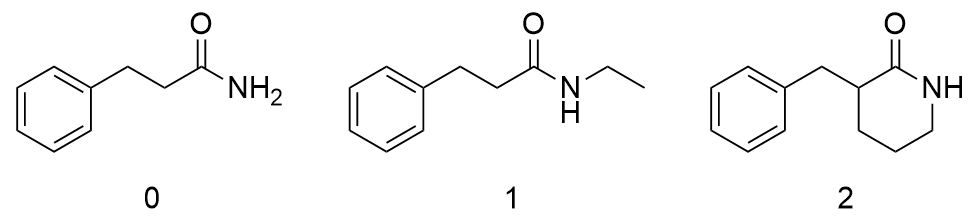

In [2]:
smi = ["NC(CCC1=CC=CC=C1)=O", "O=C(NCC)CCC1=CC=CC=C1", "O=C(NCCC1)C1CC2=CC=CC=C2"]
mol = [Chem.MolFromSmiles(m) for m in smi]
fps = [np.array(Chem.rdMolDescriptors.GetMorganFingerprintAsBitVect(m, 2, 1024)) for m in mol]

df = pd.DataFrame(fps, columns=[str(i) for i in range(1024)])
df

,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


---

Let's see which are the active (non-zero) bits in each fingerprint. Note that some of them are similar between fingerprints

In [3]:
non_zero_0 = df.loc[0].to_numpy().nonzero()
non_zero_0

(array([ 21,  42,  64,  66,  80, 140, 147, 175, 219, 356, 389, 540, 545,
        638, 650, 726, 730, 807, 849, 874, 893], dtype=int64),)

In [4]:
non_zero_1 = df.loc[1].to_numpy().nonzero()
non_zero_1

(array([ 21,  33,  41,  42,  64,  66,  80, 128, 175, 197, 219, 294, 356,
        389, 540, 565, 600, 650, 681, 697, 702, 726, 730, 807, 849, 893],
       dtype=int64),)

In [5]:
non_zero_2 = df.loc[2].to_numpy().nonzero()
non_zero_2

(array([   4,   10,   42,   64,   80,   88,   90,  175,  278,  301,  305,
         314,  327,  356,  389,  403,  432,  458,  587,  650,  726,  730,
         742,  842,  848,  849,  881,  926, 1019], dtype=int64),)

More active bits are the same for structures 0 and 1 than for 0 and 2.

In [6]:
union_0_1 = np.intersect1d(non_zero_0, non_zero_1)
union_0_1

array([ 21,  42,  64,  66,  80, 175, 219, 356, 389, 540, 650, 726, 730,
       807, 849, 893], dtype=int64)

In [7]:
union_0_2 = np.intersect1d(non_zero_0, non_zero_2)
union_0_2

array([ 42,  64,  80, 175, 356, 389, 650, 726, 730, 849], dtype=int64)

In [8]:
# Bits that are active in all three molecules
union = np.intersect1d(non_zero_2, np.intersect1d(non_zero_0, non_zero_1))
union

array([ 42,  64,  80, 175, 356, 389, 650, 726, 730, 849], dtype=int64)

---

Let's generate the fingerprints again but, this time, we use the `bitInfo` parameter to save information on the atoms involved in setting a bit, which will allow us to draw the corresponding substructure. 

In [9]:
bi0 = {}
fp0 = AllChem.GetMorganFingerprintAsBitVect(mol[0], 2, 1024, bitInfo=bi0)

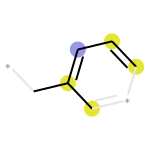

In [10]:
# Bit 42 is active in all molecules, and corresponds to a substructure of the aromatic ring
Draw.DrawMorganBit(mol[0], 42, bi0, useSVG=True)

Bit 42 should correspond to the same substructure if we get the `bitInfo` from molecule 1:

In [11]:
bi1 = {}
fp1 = AllChem.GetMorganFingerprintAsBitVect(mol[1], 2, 1024, bitInfo=bi1)

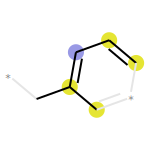

In [12]:
Draw.DrawMorganBit(mol[1], 42, bi1, useSVG=True)

If you want to explore drawing a different substructure responsible for an active bit, replace the second argument in `Draw.DrawMorganBit()` by the value you want.

Try using other values in `union` to see if they are all common substructures for the three molecules. You can also try using a value that is not present in the list of active bits and see what happens.

---

Now, let's see which bits are active in one fingerprint, but not in another.

In [13]:
# Bits active in 2 but not in 0
diff = np.setdiff1d(non_zero_2, non_zero_0)
diff

array([   4,   10,   88,   90,  278,  301,  305,  314,  327,  403,  432,
        458,  587,  742,  842,  848,  881,  926, 1019], dtype=int64)

In [14]:
bi2 = {}
fp2 = AllChem.GetMorganFingerprintAsBitVect(mol[2], 2, 1024, bitInfo=bi2)

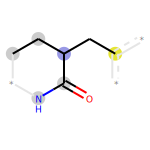

In [15]:
# This substructure is centered on a tertiary carbon atom and is unique to 2
Draw.DrawMorganBit(mol[2], 881, bi2, useSVG=True)

Note that the substructure below, which corresponds to a nitrogen atom bonded to two atoms, should also be present in 1 since, in both molecules, the nitrogen is bonded to two carbon atoms: one from a carbonyl and the other from a methylene.

However, the bits they activate are different (it's bit 90 for 2 and 128 for 1). I believe this is because, in molecule 2, one of the atoms is part of a cycle, and ends up being considered as a different atom type.

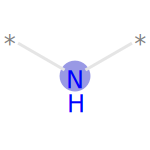

In [16]:
Draw.DrawMorganBit(mol[2], 90, bi2, useSVG=True)

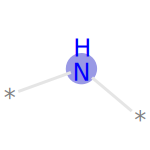

In [17]:
# Bit 128 is active in 1, but not in 2, even though they both correspond to N bonded to two C atoms
Draw.DrawMorganBit(mol[1], 128, bi1, useSVG=True)